initialize sigma randomly with "initial" function and plot the grid using "graphic" function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def initial(l):
    p=0.5
    sigma=np.random.uniform(size=(l,l))
    z=(sigma<p).astype(int)
    z[z==0]=-1
    return z
def graphic(z,l):
    x=np.arange(l)
    y=np.arange(l)
    plt.pcolormesh(x,y,z,cmap='gray_r')

"energy" function to calculate energy of the grid

In [3]:
def energy(sigma,l):
    E=np.sum(sigma[:,:l-1]*sigma[:,1:l])+np.sum(sigma[:l-1,:]*sigma[1:l,:])+np.sum(sigma[:,l-1]*sigma[:,0])+np.sum(sigma[l-1,:]*sigma[0,:])
    return E   

"magnetization" function to calculate magnetization of the grid

In [4]:
def magnetization(sigma):
    return np.sum(sigma)

"cor" function to calculate correlation of the "data"

In [5]:
from scipy import stats
def cor(data,l):
    n=len(data)
    u=0
    for i in range(0,n//3):
         u=stats.pearsonr(data[:n-i],data[i:])[0]
         if u<(1/np.e):
            return i
    return 0

"sv_excel" function to save "data" which is a pandas dataframe in to an excel file 

In [6]:
from openpyxl import load_workbook
def sv_excel(data,j,fname):
    path=r"%s"%fname
    book = load_workbook(path)
    writer = pd.ExcelWriter(path, engine = 'openpyxl')
    writer.book = book
    data.to_excel(writer,sheet_name="{:.2f}".format(j))
    writer.save()
    writer.close()

"relax" function to make sure that the system has reached to its stable state 

In [8]:
def relax(sigma,J,l,E,M):
    delta_E=[0,4,8]
    prob=list(map(np.exp,[0,-4*J,-8*J]))
    prob=dict(zip(delta_E,prob))
    for i in range(1000*l*l):
        r=np.random.randint(l,size=2)
        dE=2*sigma[r[0],r[1]]*(sigma[r[0]-1,r[1]]+sigma[(r[0]+1)%l,r[1]]+sigma[r[0],r[1]-1]+sigma[r[0],(r[1]+1)%l])
        if dE<0:
            sigma[r[0],r[1]]=-sigma[r[0],r[1]]
            E=E+dE
            M=M+2*sigma[r[0],r[1]]
        else:
            rand=np.random.uniform()
            if rand<prob[dE]:
                sigma[r[0],r[1]]=-sigma[r[0],r[1]]
                E=E+dE
                M=M+2*sigma[r[0],r[1]]
    return sigma,E,M

"spin" function to calculate spin-spin correlation

In [455]:
from scipy import stats
import math 
def spin(a):
    n=np.shape(a)[0]
    u=0
    add=np.zeros(n//2)
    cordistance=0
    delete_nan=np.zeros(n//2)
    for row in range(0,n):
        for i in range(0,n//2):
             u=stats.pearsonr(a[row,:n-i],a[row,i:])[0]
             if math.isnan(u):
                 u=0
                 delete_nan[i]+=1
             add[i]+=u
    
    return add/(n-delete_nan)

main body:

In [462]:
from scipy.constants import k as K 
import pandas as pd 
from openpyxl import Workbook
#J=[0.3]
l=70
J=np.append(np.arange(0.1,0.4,0.05),np.arange(0.41,0.6,0.01))
J=np.append(J,np.arange(0.6,1,0.05))
delta_E=[0,4,8]
sigma=initial(l)
E=energy(sigma,l)
M=magnetization(sigma)
dictionary={}
#excel file to save data:
wb = Workbook()
fname='EM-%i.xlsx'%l
wb.save(filename =fname)
for item in J:
    prob=list(map(np.exp,[0,-4*item,-8*item]))
    prob=dict(zip(delta_E,prob))
    print('J=',item)
    data_e=[]
    data_m=[]
    sigma,E,M=relax(sigma,item,l,E,M)
    print('relaxed')
    n=1000*l*l
    temp=0
    g=0
    S=[]
    while g<30:
        if temp==0:
            for j in range(n):
                r=np.random.randint(l,size=2)
                dE=2*sigma[r[0],r[1]]*(sigma[r[0]-1,r[1]]+sigma[(r[0]+1)%l,r[1]]+sigma[r[0],r[1]-1]+sigma[r[0],(r[1]+1)%l])
                if dE<0:
                    sigma[r[0],r[1]]=-sigma[r[0],r[1]]
                    E=E+dE
                    M=M+2*sigma[r[0],r[1]]
                    
                else:
                    rand=np.random.uniform()
                    if rand<prob[dE]:
                        sigma[r[0],r[1]]=-sigma[r[0],r[1]]
                        E=E+dE
                        M=M+2*sigma[r[0],r[1]]
                        
                data_e.append(E)
                data_m.append(M)
                #S.append(sigma.copy())
            temp=cor(data_e[::l*l],l)*l*l
        print('data1')
        if temp!=0 and g==0:
            data_e=data_e[::temp]
            data_m=data_m[::temp]
            S=S[::temp]
            g=len(data_e)
            print('g=',g)
            print('cor=',temp)
        if g!=0 and g<30:
            for j in range(temp):
                r=np.random.randint(l,size=2)
                dE=2*sigma[r[0],r[1]]*(sigma[r[0]-1,r[1]]+sigma[(r[0]+1)%l,r[1]]+sigma[r[0],r[1]-1]+sigma[r[0],(r[1]+1)%l])
                if dE<0:
                    sigma[r[0],r[1]]=-sigma[r[0],r[1]]
                    E=E+dE
                    M=M+2*sigma[r[0],r[1]]
                else:
                    rand=np.random.uniform()
                    if rand<prob[dE]:
                        sigma[r[0],r[1]]=-sigma[r[0],r[1]]
                        E=E+dE
                        M=M+2*sigma[r[0],r[1]]
            data_e.append(E)
            data_m.append(M)
            #S.append(sigma.copy())
            g+=1
    data_e=item*np.asarray(data_e)
    data_m=abs(np.asarray(data_m))
    df=pd.DataFrame(list(zip(data_e,data_m)),columns=['E','M'])
    #dictionary["{:.2f}".format(item)]=list(S[:100])
    sv_excel(df,item,fname)


J= 0.1
relaxed
data1
g= 1000
cor= 4900
J= 0.15000000000000002
relaxed
data1
g= 1000
cor= 4900
J= 0.20000000000000004
relaxed
data1
g= 1000
cor= 4900
J= 0.25000000000000006
relaxed
data1
g= 1000
cor= 4900
J= 0.30000000000000004
relaxed
data1
g= 500
cor= 9800
J= 0.3500000000000001
relaxed
data1
g= 500
cor= 9800
J= 0.40000000000000013
relaxed
data1
g= 143
cor= 34300
J= 0.41
relaxed
data1
g= 200
cor= 24500
J= 0.42
relaxed
data1
g= 100
cor= 49000
J= 0.43
relaxed
data1
g= 40
cor= 122500
J= 0.44
relaxed
data1
g= 53
cor= 93100
J= 0.45
relaxed
data1
g= 143
cor= 34300
J= 0.46
relaxed
data1
g= 112
cor= 44100
J= 0.47000000000000003
relaxed
data1
g= 200
cor= 24500
J= 0.48000000000000004
relaxed
data1
g= 334
cor= 14700
J= 0.49000000000000005
relaxed
data1
g= 250
cor= 19600
J= 0.5
relaxed
data1
g= 250
cor= 19600
J= 0.51
relaxed
data1
g= 250
cor= 19600
J= 0.52
relaxed
data1
g= 250
cor= 19600
J= 0.53
relaxed
data1
g= 334
cor= 14700
J= 0.54
relaxed
data1
g= 334
cor= 14700
J= 0.55
relaxed
data1
g= 500
co

In [423]:
keys=list(dictionary.keys())
data=np.zeros(n//2)
df_cor=pd.DataFrame(columns=keys)
for key in keys:
    values=dictionary[key]
    n=np.shape(values[0])[0]
    data=np.zeros(n//2)
    for coutner,v in enumerate(values):
        data+=spin(v)
    data/=coutner
    df_cor[key]=data
    

path=r'cor_length.xlsx'
book = load_workbook(path)
#book.title='J=%i'%l
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df_cor.to_excel(writer,sheet_name='l=%i'%l)
writer.save()
writer.close()


In [229]:
import xlrd
xls = xlrd.open_workbook(r'data_EM-40.xlsx', on_demand=True)
excel_file_path='data_EM-40.xlsx'
mean_m=[]
mean_e=[]
sheet_names=xls.sheet_names()
sheet_names.remove('Sheet1')
for sheet in sheet_names:
    df=pd.read_excel(excel_file_path,sheet_name=sheet)
    mean_m.append(df.iloc[-1]['M'])
    mean_e.append(df.iloc[-1]['E'])

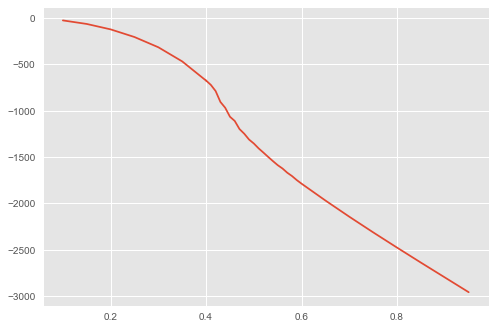

In [231]:
J=np.append(np.arange(0.1,0.4,0.05),np.arange(0.4,0.6,0.01))
J=np.append(J,np.arange(0.6,1,0.05))
plt.style.use('ggplot')
plt.plot(J,mean_e)

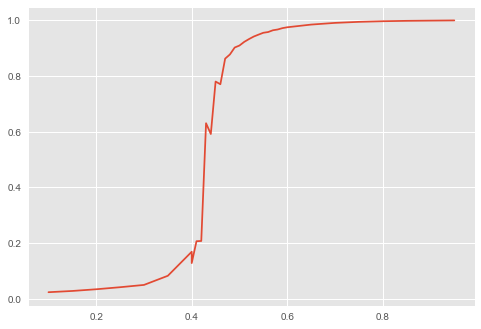

In [234]:
J=np.append(np.arange(0.1,0.4,0.05),np.arange(0.4,0.6,0.01))
J=np.append(J,np.arange(0.6,1,0.05))
plt.style.use('ggplot')
plt.plot(J,np.array(mean_m)/(40*40),ms=4)

In [282]:
import xlrd
xls = xlrd.open_workbook(r'data_EM-40.xlsx', on_demand=True)
excel_file_path='data_EM-40.xlsx'
var_m=[]
var_e=[]
sheet_names=xls.sheet_names()
sheet_names.remove('Sheet1')
for sheet in sheet_names:
    df=pd.read_excel(excel_file_path,sheet_name=sheet)
    var_m.append(np.var(df['M']))
    var_e.append(np.var(df['E']))

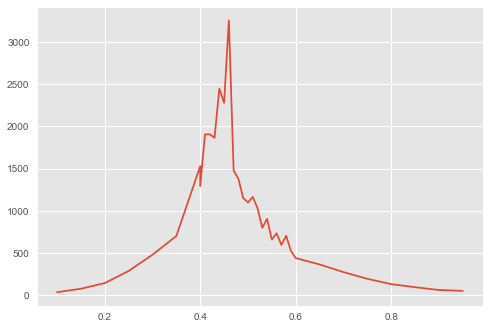

In [385]:
J=np.append(np.arange(0.1,0.4,0.05),np.arange(0.4,0.6,0.01))
J=np.append(J,np.arange(0.6,1,0.05))
plt.style.use('ggplot')
#plt.plot(J,var_m,'ro')
plt.plot(J,var_e)
plt.show()

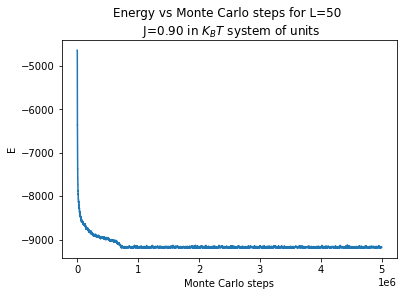

In [517]:
def plt_E_vs_MonteCarlo(df,l,J,n):
    plt.plot(df['n'],df['E'])
    plt.ylabel('E')
    plt.xlabel('Monte Carlo steps')
    #plt.plot(np.arange(0,n),[min(df['E'][500:])]*n)
    #plt.plot(np.arange(0,n),[max(df['E'][500:])]*n)
    plt.title('Energy vs Monte Carlo steps for L=%i \n J=%0.2f in $K_BT$ system of units'%(l,J) )
    #print(max(df['E'][500:])-min(df['E'][500:]))
plt_E_vs_MonteCarlo(df,l,J,n)

262


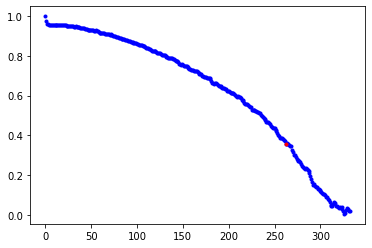

In [326]:
cor=[]
bool=1
a=0
for i in range(0,n//3):
    cor.append(np.corrcoef(df['E'][:n-i],df['E'][i:])[0,1])
    if cor[i]<1/np.e and bool==1:
        print(i)
        a=i
        bool=0
plt.plot(np.arange(0,n//3),cor,'bo',ms=3)
if a!=0:
    plt.plot(a,cor[a],'ro',ms=3)

In [308]:
np.e

2.718281828459045

In [298]:

np.corrcoef(df['E'][:n-200],df['E'][200:])


array([[1.        , 0.01236434],
       [0.01236434, 1.        ]])

[-2090.9280000000017, -2096.059999999998, -2080.928, -2091.2959999999994, -2094.4879999999994, -2092.644000000001]


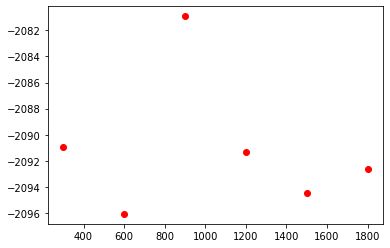

In [275]:
b=[]
for i in range (300,n,300):
    maximum=np.mean(df['E'][i-300:i])
    b.append(maximum)
plt.plot(np.arange(300,n,300),b,'ro')
print(b)

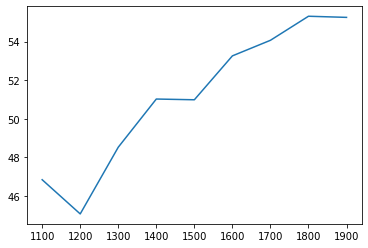

In [188]:
std=[]
bool=0
a=0
for i in range(1100,n,100):
    std.append(np.std(df['E'][1000:i]))

#print(abs(std[a]-std[a-20]))
plt.plot(np.arange(1100,n,100),std)
if a!=0:
    plt.plot(a,std[a],'ro')

28.184530224930267
-4720.294


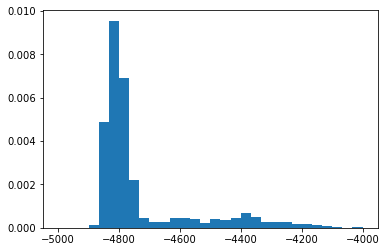

In [164]:
plt.hist(df['E'],density=True,range=(-5000,-4000),bins=30)
print(np.std(df['E'][1000:]))
print(np.mean(df['E']))
#plt.plot(np.arange())

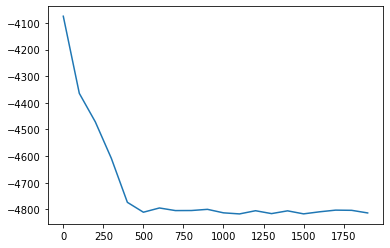

In [140]:
mean=[]
for i in range(0,n,100):
    mean.append(np.mean(list(df['E'][i:i+100])))
plt.plot(np.arange(0,n,100),mean)


In [147]:
dff=[]
bool=0
a=0
for count,item in enumerate(mean):
    p=abs(mean[(count+1)%len(mean)]-mean[count])
    dff.append(p)
    if p<0.3 and bool==0:
        bool=1
        a=count
        print(a)


7


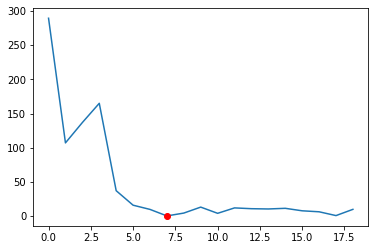

In [148]:
plt.plot(np.arange(len(dff)-1),dff[:len(dff)-1])
if a!=0:
    plt.plot(a,dff[a],'ro')

In [633]:
list(df['E'][:2])

[-5136.4, -6048.4]

In [360]:
def g(x):
    if x>=0:
        return np.exp(-x)
    else:
        return 0

n=1000000
x=sigma
numbers=[]
alpha=5
for i in range(n):
    r=np.random.randint(l,size=2)
    dE=-2*sigma[r[0],r[1]]*(sigma[r[0]-1,r[1]]+sigma[r[0]+1,r[1]]+sigma[r[0],r[1]-1]+sigma[r[0],r[1]+1])
    if g(y)>g(x):
        x=y
    else:
        r=np.random.uniform()
        if r<(g(y)/g(x)):
            x=y
    numbers.append(x)



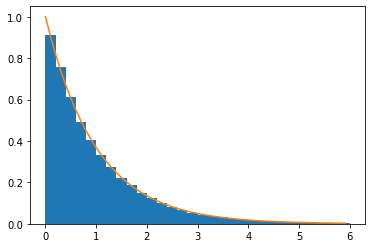

In [368]:
plt.hist(numbers,density=True,bins=30,range=(0,6))
plt.plot(np.arange(0,6,0.1),np.exp(-np.arange(0,6,0.1)))

In [337]:

prob=list(map(np.exp,[-4,-8]))
prob=dict(zip(delta_E,prob))
print(prob)


{4: 0.01831563888873418, 8: 0.00033546262790251185}


In [277]:
2*np.random.randint(2,size=(3,3))-1

array([[-1,  1,  1],
       [ 1, -1, -1],
       [-1,  1, -1]])

(array([14245.,  5935.,  4649.,  4298.,  3900.,  3762.,  3432.,  3374.,
         3196.,  3178.,  3203.,  3211.,  3321.,  3449.,  3590.,  3866.,
         4154.,  4709.,  6071., 14457.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -8.94624375e-11,  9.99999999e-02,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <a list of 20 Patch objects>)

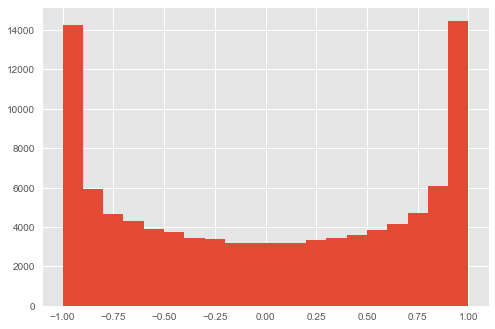

In [273]:
plt.hist(lk,bins=20)

In [332]:
#a=np.random.uniform(size=(50,50))
spin(dictionary['0.50'][4])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [366]:
stats.pearsonr([1,1,1],[1,2,3])[0]

nan

In [373]:
import math
math.isnan(stats.pearsonr([1,1,1],[1,2,3])[0])


True

In [330]:
1+Nan

NameError: name 'Nan' is not defined

In [448]:
a=np.ones(1000)
for i in range(0,1000,15):
    a[i]=-1

stats.pearsonr(a,a)

(1.0, 0.0)